# Problem 5: Problem 4 with added feature

## Import image data, normalize image pixel values, and make labels categorical

In [1]:
import numpy as np
import sys
import time
from keras import models, layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()
train_images = train_images_original.astype('float32') / 255
test_images = test_images_original.astype('float32') / 255

train_labels = to_categorical(train_labels_original)
test_labels = to_categorical(test_labels_original)

Using TensorFlow backend.


## DFS function for finding number of connected edges.

This function performs a simple DFS search on an image, and returns the number of white regions in the image.  The problem with this function is that since it needs to check every vertex of every image, and there are 784 vertices per image and 70000 total images, that means that more than 55 million vertices would have to be processed.  This would be fine if I was somehow able to vectorize this function, but every vertex must be checked and the only way I could think of doing this was through a for-loop, and np_apply.over_axis does not let me perform the operation on a list of matrices, so I need to process each image sequentially as well.  As a result, the runtime to get the connected regions of every image in MNIST totals over half an hour.  On the bright side, once this function finishes executing, the rest of the training proceeds as in Problem 4.

In [0]:
def find_num_regions(im):
  # Create a queue that will operate on a FIFO ordering, as well as a list that
  # will hold the vertices already visited in the image.
  queue = []  
  visited = []
  
  num_regions = 0
  
  # For each vertex in the image, possibly perform DFS.
  for row in range(28):
    for col in range(28):
      
      # If the vertex has not been visited yet and is a white region (less than a 0.5 pixel value),
      # then this is the start of a new white region.
      if (row,col) not in visited and im[row][col] < 0.5:
        # Incremement the number of regions in image, append the vertex to the queue, and mark this 
        # vertex as visited by adding it to the list of visited.
        num_regions += 1
        queue.append((row,col))
        visited.append((row,col))
        
        # While the queue is not empty, perform DFS.
        while len(queue) > 0:
          # Pop a vertex off the queue.
          (vr,vc) = queue.pop()
          
          # For each neighbor of the vertex, as long as the neighbor has not been
          # already visited, and as long as it is in the bounds of the image, AND
          # as long as this neighbor is also part of a white region, add it to the queue,
          # and visited lists.
          if (vr - 1, vc) not in visited and vr - 1 >= 0 and im[vr - 1][vc] < 0.5:
            queue.append((vr - 1, vc))
            visited.append((vr - 1,vc))
          if (vr + 1, vc) not in visited and vr + 1 < 28 and im[vr + 1][vc] < 0.5:
            queue.append((vr + 1, vc))
            visited.append((vr + 1,vc))
          if (vr, vc - 1) not in visited and vc - 1 >= 0 and im[vr][vc - 1] < 0.5:
            queue.append((vr, vc - 1))
            visited.append((vr,vc - 1))
          if (vr, vc + 1) not in visited and vc + 1 < 28 and im[vr][vc + 1] < 0.5:
            queue.append((vr, vc + 1))
            visited.append((vr,vc + 1))
  
  # The maximum number of regions we can have is 3, so return the normalized
  # number of regions.
  return num_regions/3

## Find the number of connected white regions in train and test data

Because this takes such a long time to execute, I keep a running update using the sys module in order to keep the user informed of how the progress is.  At the end I also print out the number of minutes it took to execute as well as the list of connected region counts for the test data in order to verify that everything went correctly.

In [3]:
regions_train = np.empty(60000)
regions_test = np.empty(10000)
  
start = time.time()
for i in range(60000):
  regions_train[i] = find_num_regions(train_images[i])
  sys.stdout.write('\r')
  sys.stdout.write("%d/60000 training images processed." % (i + 1))
print()
for i in range(10000):
  regions_test[i] = find_num_regions(test_images[i])
  sys.stdout.write('\r')
  sys.stdout.write("%d/10000 testing images processed." % (i + 1))
end = time.time()

print("\nProcessing finished in %f minutes" % ((end - start)/60))
print("List of number of connected regions for test data:")
print(regions_test)

60000/60000 training images processed.
10000/10000 testing images processed.
Processing finished in 41.803343 minutes
List of number of connected regions for test data:
[0.33333333 0.33333333 0.33333333 ... 0.33333333 0.33333333 0.66666667]


## Append the lists of region counts to their respective arrays.

I reshape the train and test data and append the train and test region counts to them.  I also print out the resulting test array to verify the appending went correctly.

In [4]:
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images_original.reshape((10000, 28 * 28))

reg_train = regions_train.reshape((60000,1))
reg_test = regions_test.reshape((10000,1))

train_ims = np.append(train_images,reg_train, axis=1)
test_ims = np.append(test_images,reg_test, axis=1)

print("New test data array:")
print(test_ims)

New test data array:
[[0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.         0.33333333]
 ...
 [0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.         0.66666667]]


## Create the network, same as Problem 4.

The only difference here is that our input size is now 28 * 28 + 1, because of the additional feature.

## Network Architecture

In [5]:
network = models.Sequential()
network.add(layers.Dense(785, activation='relu', input_shape=(785,)))
network.add(layers.Dense(10, activation='softmax'))
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 785)               617010    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7860      
Total params: 624,870
Trainable params: 624,870
Non-trainable params: 0
_________________________________________________________________


## Compilation and training step

I have found that adding this feature produces a very negligible increase in accuracy.  As seen above, the region finding and appending is correct, so the only conclusion here is that adding the number of connected regions to the feature vector for each image does nothing when performing mini-batch stochastic gradient descent.

In [6]:
network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 10
history = network.fit(train_ims, 
                      train_labels, 
                      epochs=epochs, 
                      batch_size=128, 
                      validation_data=(test_ims, test_labels))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 49us/step - loss: 1.0602 - acc: 0.7780 - val_loss: 1.9997 - val_acc: 0.8715
Epoch 2/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.4988 - acc: 0.8794 - val_loss: 1.6713 - val_acc: 0.8936
Epoch 3/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.4018 - acc: 0.8969 - val_loss: 1.5239 - val_acc: 0.9036
Epoch 4/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.3565 - acc: 0.9051 - val_loss: 1.4313 - val_acc: 0.9090
Epoch 5/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.3281 - acc: 0.9110 - val_loss: 1.3638 - val_acc: 0.9129
Epoch 6/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.3075 - acc: 0.9165 - val_loss: 1.2951 - val_acc: 0.9180
Epoch 7/10
60000/60000 [==============================] - 2s 36us/step - loss: 0

## Plots of train/test loss, accuracy

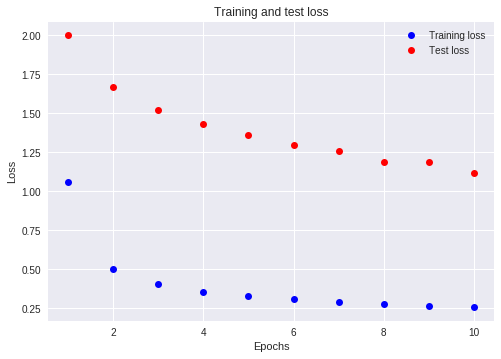

In [7]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

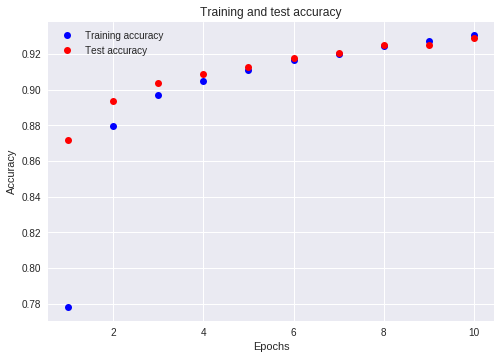

In [8]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()